# Building Makemore Part 2: Multi-Layer Perceptron

[Reference Video](https://youtu.be/TCH_1BHY58I?list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ)

[Reference Paper](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)

## Part 1: Explore the Dataset

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
words = open('./names.txt').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [4]:
len(words)

32033

## Part 2: Label the Dataset

In [5]:
# mappings from letter to index, and index to letter
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(stoi)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}


In [6]:
# build an adjustable block-size
block_size = 3
X, Y = [], [] # inputs and labels
for w in words[:5]:

    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix] # shift context

X = torch.tensor(X)
Y = torch.tensor(Y)

In [7]:
X[:4], Y[:4]

(tensor([[ 0,  0,  0],
         [ 0,  0,  5],
         [ 0,  5, 13],
         [ 5, 13, 13]]),
 tensor([ 5, 13, 13,  1]))

## Part 3: Semantic Character Representation in a 2-D Space

### 3.1 Image of neural net from [A Neural Probabilistic Language Model](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf) by Bergio et. al.

![Image of neural net for reference](./network.png)


In [8]:
# build a character embedding in a 2-dim space
g = torch.Generator().manual_seed(2147483647)
C = torch.randn(27,2, generator=g)
C.shape, C[:4]

(torch.Size([27, 2]),
 tensor([[ 1.5674, -0.2373],
         [-0.0274, -1.1008],
         [ 0.2859, -0.0296],
         [-1.5471,  0.6049]]))

### 3.2 Pull a name out of the Character Embedding

In [9]:
# index the character embedding using a word
name = []
for w in words[:1]:
    for ch in w + '.':
        ix = stoi[ch]
        name.append(ix) # indices of name 'emma
    
C[name] # embedding of name 'emma'

tensor([[-0.4713,  0.7868],
        [ 2.4448, -0.6701],
        [ 2.4448, -0.6701],
        [-0.0274, -1.1008],
        [ 1.5674, -0.2373]])

### 3.3: Embedding the entire data set

In `emb`, the embedding of our entire dataset of characater sequences (trigrams, in the most naive approach), the first axis denotes each character sequence used as context (ex. previous 3 letters). Then, the second axis indexes which character in the sequence (first, second, or third). And finally, the third axis denotes the elmenents of the n-dimensional space of character embeddings

In [10]:
# embed the entire dataset
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [11]:

W1 = torch.randn((6,100), generator=g)
b1 = torch.randn(100, generator=g)

In [12]:
# emb @ W1 + b1 # What we want to do.

### 3.4: Wrangling the embedding data (Naive approach)

In [13]:
# Naive approach to concatentating embeddings of each trigram into an (n, 6) array
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1)[:10]


tensor([[ 1.5674, -0.2373,  1.5674, -0.2373,  1.5674, -0.2373],
        [ 1.5674, -0.2373,  1.5674, -0.2373, -0.4713,  0.7868],
        [ 1.5674, -0.2373, -0.4713,  0.7868,  2.4448, -0.6701],
        [-0.4713,  0.7868,  2.4448, -0.6701,  2.4448, -0.6701],
        [ 2.4448, -0.6701,  2.4448, -0.6701, -0.0274, -1.1008],
        [ 1.5674, -0.2373,  1.5674, -0.2373,  1.5674, -0.2373],
        [ 1.5674, -0.2373,  1.5674, -0.2373, -1.0725,  0.7276],
        [ 1.5674, -0.2373, -1.0725,  0.7276, -0.0707,  2.4968],
        [-1.0725,  0.7276, -0.0707,  2.4968,  0.6772, -0.8404],
        [-0.0707,  2.4968,  0.6772, -0.8404, -0.1158, -1.2078]])

In [14]:
# unbind the trigrams, achieve same as above
torch.cat(torch.unbind(emb, 1), 1)[:10] # (n, 6) shape instead of (n, 3, 2)

tensor([[ 1.5674, -0.2373,  1.5674, -0.2373,  1.5674, -0.2373],
        [ 1.5674, -0.2373,  1.5674, -0.2373, -0.4713,  0.7868],
        [ 1.5674, -0.2373, -0.4713,  0.7868,  2.4448, -0.6701],
        [-0.4713,  0.7868,  2.4448, -0.6701,  2.4448, -0.6701],
        [ 2.4448, -0.6701,  2.4448, -0.6701, -0.0274, -1.1008],
        [ 1.5674, -0.2373,  1.5674, -0.2373,  1.5674, -0.2373],
        [ 1.5674, -0.2373,  1.5674, -0.2373, -1.0725,  0.7276],
        [ 1.5674, -0.2373, -1.0725,  0.7276, -0.0707,  2.4968],
        [-1.0725,  0.7276, -0.0707,  2.4968,  0.6772, -0.8404],
        [-0.0707,  2.4968,  0.6772, -0.8404, -0.1158, -1.2078]])

#### Summary of 3.4: 

We started off with a tensor of dimension `(n, block_size, embedding_space_dim)`.

Then, for each n-gram or block of characters, we used `torch.unbind` and then `torch.cat` to concatentate each embedding along eachother.

So, if we now use a trigram with character embeddings in a 2-dimensional space, we will then have a 6-element long input to the network.

### 3.5: More efficient approach using `tensor.view`

[ezyang's blog post on PyTorch internals](http://blog.ezyang.com/2019/05/pytorch-internals/)

In [15]:
a = torch.arange(18)
a

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

In [16]:
a.view(2,9)

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8],
        [ 9, 10, 11, 12, 13, 14, 15, 16, 17]])

In [17]:
a.view(3,3,2)

tensor([[[ 0,  1],
         [ 2,  3],
         [ 4,  5]],

        [[ 6,  7],
         [ 8,  9],
         [10, 11]],

        [[12, 13],
         [14, 15],
         [16, 17]]])

In [18]:
# Reshape the embedding efficiently
emb = C[X]

emb = emb.view(emb.shape[0], 6) 
# OR
emb = emb.view(emb.shape[0], -1) # -1 means "whatever is needed to make the shape work"

## Part 2: Building the network

### 2.1: Hidden Layer

Since we already reshaped our data, the input layer is done.

Now we will create the hidden layer.

In [19]:
emb @ W1 + b1 # Works now !

tensor([[-1.6952e+00,  8.5502e+00,  1.6284e+00,  ...,  2.2642e+00,
         -1.9505e-01,  1.8469e+00],
        [ 2.8741e-01,  4.3343e+00,  1.0142e+00,  ...,  2.8221e+00,
          3.9128e+00,  3.4733e+00],
        [-3.1026e+00,  9.9601e+00, -1.3306e+00,  ..., -5.7069e-01,
         -5.9107e+00, -6.9120e-03],
        ...,
        [-4.3248e+00,  7.4938e+00, -1.6386e+00,  ..., -5.1557e+00,
         -3.3276e+00, -3.2464e+00],
        [-1.4951e+00,  5.6195e+00,  2.5079e+00,  ..., -1.0607e+00,
         -5.2543e-01,  3.4893e+00],
        [-1.4982e+00,  8.5941e+00,  1.8897e+00,  ...,  2.4983e+00,
          6.9596e+00,  2.6822e+00]])

In [20]:
# Hidden layer activation using tanh
emb = C[X]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # hidden layer activation
h.shape

torch.Size([32, 100])

In [21]:
W2 = torch.randn((100,27), generator=g)
b2 = torch.randn(27, generator=g)

In [22]:
logits = h @ W2 + b2 # log counts
logits.shape

torch.Size([32, 27])

Text(0.5, 0, 'Probability of each character output')

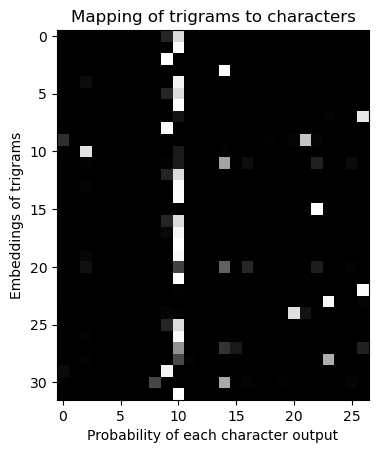

In [23]:
counts = logits.exp()
probs = counts / counts.sum(1, keepdim=True)
plt.imshow(probs.detach().numpy(), cmap='gray')
plt.title("Mapping of trigrams to characters")
plt.ylabel("Embeddings of trigrams")
plt.xlabel("Probability of each character output")

In [24]:
probs[:, 1] # probabiility of letter 'a' for each trigram

tensor([2.0283e-10, 9.0695e-12, 1.5368e-13, 3.1758e-10, 3.0845e-09, 2.0283e-10,
        3.0830e-12, 3.2550e-11, 1.6815e-12, 2.0269e-09, 5.3863e-08, 2.8552e-06,
        2.0283e-10, 2.6391e-09, 6.2336e-07, 3.5843e-08, 2.0283e-10, 2.8360e-10,
        2.0670e-09, 1.7086e-08, 1.6384e-09, 4.1033e-14, 8.1859e-12, 5.6464e-15,
        1.5201e-10, 2.0283e-10, 9.9325e-10, 5.6630e-08, 2.7953e-11, 6.6081e-15,
        9.7404e-10, 9.1782e-12])

## Part 3: Loss function

We will use the negative log likelihood as the loss function, to east computation and so that minimizing the loss function means optimizing the network.

Previously, we manually calculated each step of the negative log likelihood, now we will use Torch's `cross_entropy` function that takes in the logits, and outputs the negative log likelihood as shown below. This is also much more efficient, and better able to handle a larger range of inputs (without getting exploding `.exp()` numbers)

In [25]:
-probs[torch.arange(32), Y].log().mean()

tensor(17.7697)

In [26]:
loss = F.cross_entropy(logits, Y)
loss

tensor(17.7697)

## Part 4: Training the net

#### Definitions:

<strong>Batch Gradient Descent (super slow, but accurate)</strong>: Gradient Descent in which every training example is used to characterize the gradient of the loss function, in each step in training. 

<strong>Stochastic Gradient Descent (fast, but inaccurate)</strong> Gradient descent in which only one training example is used to approximate the gradient of the loss function at each step of training. 

<strong>Mini-Batch Gradient Descent(balance of speed and accuracy)</strong> Gradient descent in which a mini-batch of samples is used to approximate the gradient of the loss function at each step of training.

#### Approach:

We will first try full-batch gradient descent, see how slow it is, then use mini-batches.

### 4.1: Gradient descent (full-batch)

This will use the entire dataset for each forward pass and backward pass. This is extremely inefficient and we will optimize this later.

In [27]:
# use whole dataset
block_size = 3
X, Y = [], [] # inputs and labels
for w in words:

    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix] # shift context

X = torch.tensor(X)
Y = torch.tensor(Y)

In [28]:
# redo everything compactly
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [29]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6,100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100,27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

print("Total parameters:", sum(p.nelement() for p in parameters))

Total parameters: 3481


In [30]:
%%timeit -r 1 -n 1
eta = 0.1
epochs = 10
for epoch in range(epochs):
    emb = C[X]
    # forward pass
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2 # (n, 27)
    loss = F.cross_entropy(logits, Y)
    print(f"Epoch {epoch+1}: {loss.item():.3f}")
    # backward pass
    for p in parameters:
        p.grad = None # resets all gradients
    loss.backward() # updates all gradients in parameters
    for p in parameters:
        p.data += -eta * p.grad


Epoch 1: 19.505
Epoch 2: 17.084
Epoch 3: 15.777
Epoch 4: 14.833
Epoch 5: 14.003
Epoch 6: 13.253
Epoch 7: 12.580
Epoch 8: 11.983
Epoch 9: 11.471
Epoch 10: 11.052
4.15 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


### 4.2: Mini-batch gradient descent

In [31]:
# reinitialize meta-parameters
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6,100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100,27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

print("Total parameters:", sum(p.nelement() for p in parameters))

Total parameters: 3481


In [32]:
%%timeit -r 1 -n 1

eta = 0.1
epochs = 100
batch_size = 32


for epoch in range(epochs):
    # construct mini-batch
    ix = torch.randint(0, X.shape[0], (batch_size,))
    emb = C[X[ix]] # (batch_size)
    # forward pass
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2 # (n, 27)
    loss = F.cross_entropy(logits, Y[ix])
    print(f"Epoch {epoch}: {loss.item():.3f}")
    # backward pass
    for p in parameters:
        p.grad = None # resets all gradients
    loss.backward() # updates all gradients in parameters
    for p in parameters:
        p.data += -eta * p.grad


Epoch 0: 20.406
Epoch 1: 17.292
Epoch 2: 15.095
Epoch 3: 14.746
Epoch 4: 13.786
Epoch 5: 12.651
Epoch 6: 9.495
Epoch 7: 12.660
Epoch 8: 12.788
Epoch 9: 12.106
Epoch 10: 12.219
Epoch 11: 10.533
Epoch 12: 9.558
Epoch 13: 9.654
Epoch 14: 8.940
Epoch 15: 10.287
Epoch 16: 9.487
Epoch 17: 9.807
Epoch 18: 9.647
Epoch 19: 11.417
Epoch 20: 9.159
Epoch 21: 6.715
Epoch 22: 6.551
Epoch 23: 7.640
Epoch 24: 7.701
Epoch 25: 8.134
Epoch 26: 6.903
Epoch 27: 8.133
Epoch 28: 5.517
Epoch 29: 4.473
Epoch 30: 8.320
Epoch 31: 6.382
Epoch 32: 7.373
Epoch 33: 6.898
Epoch 34: 7.664
Epoch 35: 4.916
Epoch 36: 6.776
Epoch 37: 6.068
Epoch 38: 6.001
Epoch 39: 6.036
Epoch 40: 7.013
Epoch 41: 4.556
Epoch 42: 6.632
Epoch 43: 6.830
Epoch 44: 7.233
Epoch 45: 4.993
Epoch 46: 5.750
Epoch 47: 4.614
Epoch 48: 5.168
Epoch 49: 5.474
Epoch 50: 4.555
Epoch 51: 4.056
Epoch 52: 5.484
Epoch 53: 5.163
Epoch 54: 5.608
Epoch 55: 4.148
Epoch 56: 5.459
Epoch 57: 5.145
Epoch 58: 4.499
Epoch 59: 5.737
Epoch 60: 5.754
Epoch 61: 4.288
Epoch

### 4.3: Variable learning rate

In [51]:
# reinitialize meta-parameters
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6,100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100,27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

print("Total parameters:", sum(p.nelement() for p in parameters))

Total parameters: 3481


In [53]:
eta = 0.01
epochs = 20000
batch_size = 128


for epoch in range(epochs):
    # construct mini-batch
    ix = torch.randint(0, X.shape[0], (batch_size,))
    emb = C[X[ix]] # (batch_size)
    # forward pass
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2 # (n, 27)
    loss = F.cross_entropy(logits, Y[ix])
    print(f"Epoch {epoch}: {loss.item():.3f}")
    # backward pass
    for p in parameters:
        p.grad = None # resets all gradients
    loss.backward() # updates all gradients in parameters
    for p in parameters:
        p.data += -eta * p.grad


Epoch 0: 2.572
Epoch 1: 2.548
Epoch 2: 2.389
Epoch 3: 2.542
Epoch 4: 2.666
Epoch 5: 2.387
Epoch 6: 2.509
Epoch 7: 2.551
Epoch 8: 2.632
Epoch 9: 2.750
Epoch 10: 2.719
Epoch 11: 2.646
Epoch 12: 2.692
Epoch 13: 2.759
Epoch 14: 2.367
Epoch 15: 2.463
Epoch 16: 2.575
Epoch 17: 2.461
Epoch 18: 2.664
Epoch 19: 2.477
Epoch 20: 2.486
Epoch 21: 2.524
Epoch 22: 2.679
Epoch 23: 2.432
Epoch 24: 2.625
Epoch 25: 2.664
Epoch 26: 2.516
Epoch 27: 2.520
Epoch 28: 2.423
Epoch 29: 2.707
Epoch 30: 2.495
Epoch 31: 2.635
Epoch 32: 2.596
Epoch 33: 2.486
Epoch 34: 2.449
Epoch 35: 2.593
Epoch 36: 2.394
Epoch 37: 2.556
Epoch 38: 2.581
Epoch 39: 2.719
Epoch 40: 2.796
Epoch 41: 2.514
Epoch 42: 2.515
Epoch 43: 2.512
Epoch 44: 2.511
Epoch 45: 2.482
Epoch 46: 2.430
Epoch 47: 2.636
Epoch 48: 2.595
Epoch 49: 2.701
Epoch 50: 2.557
Epoch 51: 2.781
Epoch 52: 2.687
Epoch 53: 2.590
Epoch 54: 2.583
Epoch 55: 2.639
Epoch 56: 2.411
Epoch 57: 2.571
Epoch 58: 2.604
Epoch 59: 2.637
Epoch 60: 2.538
Epoch 61: 2.400
Epoch 62: 2.602
Ep

### 4.4 Train / validation / test data splits

Typically, we use 80/10/10 percentage splits between training, validation, and test data as to not overfit the validation or test data

Here, we will also increase the size of the hidden layer and see if we can obtain performance increases

In [35]:
def build_dataset(words):
    block_size = 3
    X, Y = [], [] # inputs and labels
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # shift context
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

X_train, Y_train = build_dataset(words[:n1]) # 80% of data
X_valid, Y_valid = build_dataset(words[n1:n2]) # 10% of data
X_test, Y_test = build_dataset(words[n2:]) # 10% of data

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [36]:
# reinitialize meta-parameters
g = torch.Generator().manual_seed(2147483647 + 1)
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6,300), generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300,27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

print("Total parameters:", sum(p.nelement() for p in parameters))

Total parameters: 10281


In [37]:
eta = 0.001
epochs = 10000
batch_size = 64
losses = []

for epoch in range(epochs):
    # construct mini-batch
    ix = torch.randint(0, X_train.shape[0], (batch_size,))
    emb = C[X_train[ix]] # (batch_size)
    # forward pass
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2 # (n, 27)
    loss = F.cross_entropy(logits, Y_train[ix])
    print(f"Epoch {epoch}: {loss.item():.3f}")
    losses.append(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None # resets all gradients
    loss.backward() # updates all gradients in parameters
    for p in parameters:
        p.data += -eta * p.grad


Epoch 0: 24.210
Epoch 1: 26.631
Epoch 2: 27.530
Epoch 3: 27.657
Epoch 4: 24.754
Epoch 5: 24.067
Epoch 6: 31.968
Epoch 7: 29.294
Epoch 8: 26.469
Epoch 9: 25.790
Epoch 10: 28.074
Epoch 11: 28.274
Epoch 12: 29.890
Epoch 13: 24.081
Epoch 14: 29.554
Epoch 15: 26.297
Epoch 16: 25.478
Epoch 17: 26.555
Epoch 18: 27.117
Epoch 19: 25.270
Epoch 20: 26.529
Epoch 21: 26.265
Epoch 22: 26.023
Epoch 23: 25.466
Epoch 24: 24.878
Epoch 25: 28.404
Epoch 26: 26.257
Epoch 27: 25.336
Epoch 28: 25.730
Epoch 29: 22.937
Epoch 30: 27.094
Epoch 31: 27.183
Epoch 32: 23.001
Epoch 33: 26.137
Epoch 34: 22.990
Epoch 35: 28.726
Epoch 36: 24.206
Epoch 37: 25.124
Epoch 38: 25.480
Epoch 39: 28.287
Epoch 40: 23.371
Epoch 41: 26.763
Epoch 42: 27.343
Epoch 43: 22.220
Epoch 44: 26.657
Epoch 45: 25.076
Epoch 46: 23.121
Epoch 47: 22.715
Epoch 48: 24.760
Epoch 49: 23.721
Epoch 50: 28.298
Epoch 51: 29.227
Epoch 52: 30.109
Epoch 53: 23.108
Epoch 54: 26.268
Epoch 55: 17.894
Epoch 56: 21.236
Epoch 57: 25.390
Epoch 58: 25.277
Epoch 5

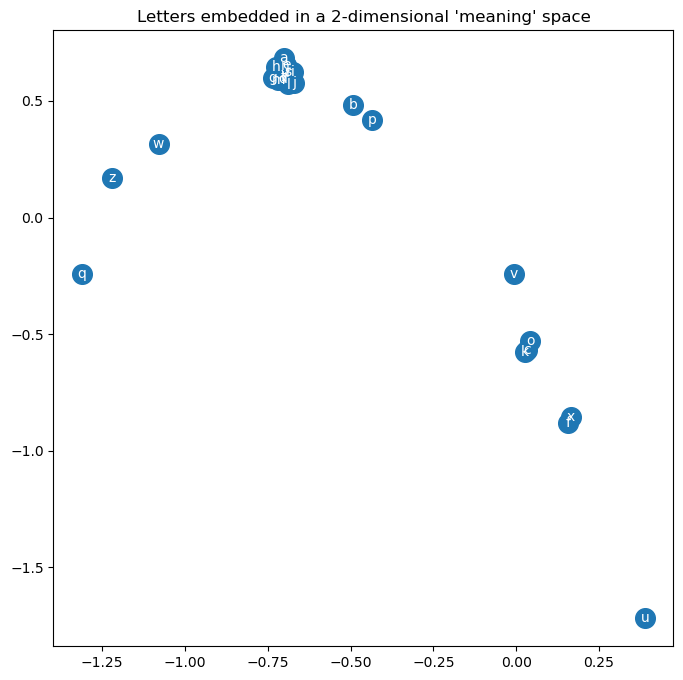

In [38]:

plt.figure(figsize=(8,8))
plt.scatter(C[1:,0].data, C[1:,1].data, s=200)
plt.title("Letters embedded in a 2-dimensional 'meaning' space")
for i in range(C.shape[0]):
    plt.text(C[i,0], C[i,1], itos[i], ha="center", va="center", color="white")

## Part 5: 10-dimensional embeddings

Due to a lack of progress in performance from our bigram exercise, we have decided that it is likely that the bottleneck of this net's performance is the limit on how it represents letters in a 2-dimensional space. Thus, we will increase the dimensionality.

In [39]:
def build_dataset(words):
    block_size = 4
    X, Y = [], [] # inputs and labels
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # shift context
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

X_train, Y_train = build_dataset(words[:n1]) # 80% of data
X_valid, Y_valid = build_dataset(words[n1:n2]) # 10% of data
X_test, Y_test = build_dataset(words[n2:]) # 10% of data

torch.Size([182580, 4]) torch.Size([182580])
torch.Size([22767, 4]) torch.Size([22767])
torch.Size([22799, 4]) torch.Size([22799])


### 5.2 Final Attempt: Beat Andrej's loss

In [40]:
# hyper-parameters
eta = 0.1
epochs = 50000
batch_size = 32
block_size = 4
emb_dims = 10

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,10), generator=g)
W1 = torch.randn((block_size * emb_dims,400), generator=g)
b1 = torch.randn(400, generator=g)
W2 = torch.randn((400,27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

print("Total parameters:", sum(p.nelement() for p in parameters))

Total parameters: 27497


In [41]:
etas = []
losses = []

In [42]:

for epoch in range(epochs):
    # construct mini-batch
    ix = torch.randint(0, X_train.shape[0], (batch_size,))
    emb = C[X_train[ix]] # (batch_size)
    # forward pass
    h = torch.tanh(emb.view(-1, block_size * emb_dims) @ W1 + b1)
    logits = h @ W2 + b2 # (n, 27)
    loss = F.cross_entropy(logits, Y_train[ix])
    print(f"Epoch {epoch}: {loss.item():.3f}")
    losses.append(loss.log().item())
    # backward pass
    for p in parameters:
        p.grad = None # resets all gradients
    loss.backward() # updates all gradients in parameters
    for p in parameters:
        p.data += -eta * p.grad if epoch < epochs // 2 else -eta * p.grad * 0.01


Epoch 0: 39.126
Epoch 1: 30.691
Epoch 2: 31.072
Epoch 3: 29.676
Epoch 4: 29.269
Epoch 5: 32.940
Epoch 6: 23.295
Epoch 7: 28.190
Epoch 8: 32.223
Epoch 9: 32.523
Epoch 10: 31.662
Epoch 11: 23.202
Epoch 12: 29.935
Epoch 13: 35.172
Epoch 14: 30.232
Epoch 15: 20.958
Epoch 16: 21.242
Epoch 17: 26.231
Epoch 18: 19.466
Epoch 19: 23.293
Epoch 20: 23.862
Epoch 21: 25.973
Epoch 22: 20.735
Epoch 23: 23.364
Epoch 24: 23.810
Epoch 25: 22.247
Epoch 26: 17.035
Epoch 27: 25.255
Epoch 28: 18.317
Epoch 29: 22.240
Epoch 30: 22.772
Epoch 31: 16.079
Epoch 32: 20.155
Epoch 33: 18.954
Epoch 34: 22.441
Epoch 35: 21.672
Epoch 36: 19.702
Epoch 37: 19.493
Epoch 38: 19.473
Epoch 39: 15.928
Epoch 40: 21.080
Epoch 41: 17.423
Epoch 42: 18.189
Epoch 43: 15.780
Epoch 44: 15.513
Epoch 45: 22.401
Epoch 46: 16.179
Epoch 47: 13.995
Epoch 48: 13.334
Epoch 49: 23.475
Epoch 50: 13.065
Epoch 51: 13.456
Epoch 52: 16.386
Epoch 53: 15.015
Epoch 54: 19.598
Epoch 55: 13.088
Epoch 56: 16.406
Epoch 57: 12.536
Epoch 58: 13.024
Epoch 5

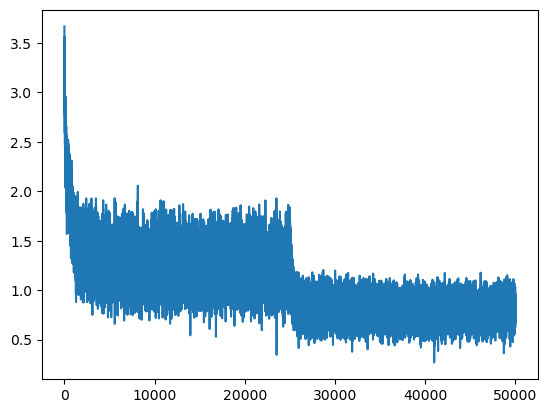

In [43]:
plt.plot(torch.linspace(0, len(losses), len(losses)), losses)

In [44]:
# validation
emb = C[X_valid] # (batch_size)
h = torch.tanh(emb.view(-1, block_size * emb_dims) @ W1 + b1)
logits = h @ W2 + b2 # (n, 27)
loss = F.cross_entropy(logits, Y_valid)
print(f"Validation loss: {loss.item():.3f}")

Validation loss: 2.259


In [45]:
# test
emb = C[X_test] # (batch_size)
h = torch.tanh(emb.view(-1, block_size * emb_dims) @ W1 + b1)
logits = h @ W2 + b2 # (n, 27)
loss = F.cross_entropy(logits, Y_test)
print(f"Test loss: {loss.item():.3f}")

Test loss: 2.258


## Part 6: Generate names 

In [46]:
for _ in range(20):

    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor(context)] # (batch_size)
        h = torch.tanh(emb.view(1, emb_dims * block_size) @ W1 + b1)
        logits = h @ W2 + b2 # (n, 27)
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

ehaloana.
mangrella.
yujkin.
miyvawadari.
laydon.
rassi.
emelelen.
kon.
amai.
junart.
sruylew.
aribella.
xoel.
dadin.
tamuyanii.
ahaane.
dherion.
lama.
izadima.
cavaisha.
